In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

trans = pd.read_csv('clean_data_final.csv', index_col = 0)

In [2]:
trans.shape

(96397, 10)

In [3]:
trans['Fraud'].sum()

1059

In [4]:
trans.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


# Creating Variables

In [5]:
trans['Merch zip'] = trans['Merch zip'].astype(str)

In [6]:
trans.Cardnum = trans['Cardnum'].astype(str)

In [7]:
trans.Merchnum = trans.Merchnum.astype(str)

In [8]:
trans['Date'] = pd.to_datetime(trans['Date'])

## Useful Combo Features

In [9]:
trans['cardnum_merchnum'] = trans.Cardnum + trans.Merchnum
trans['cardnum_merchdesc'] = trans.Cardnum + trans['Merch description']
trans['cardnum_zip'] = trans.Cardnum + trans["Merch zip"]
trans['cardnum_state'] = trans.Cardnum + trans['Merch state']

## Risk Tables

In [10]:
import calendar
trans['dow'] = trans.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [11]:
train_test = trans[trans.Date < '2016-10-01']

In [12]:
import numpy as np
#do statistical smoothing
c = 4; nmid=20; y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('dow')['Fraud'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1+ np.exp(-(num-nmid)/c))
trans['dow_risk'] = trans.dow.map(y_dow_smooth)

## Days Since and Absolute Velocity Variables

In [13]:
attributes = ['Cardnum', 'Merchnum', 'Merch description', 'cardnum_merchnum', 'cardnum_merchdesc', 'cardnum_zip', 'cardnum_state']

In [14]:
df1 = trans.copy()
final = trans.copy()
df1['check_date'] = df1.Date
df1['check_recnum'] = df1.Recnum

In [15]:
import datetime as dt
for entity in attributes:
    df_1 = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_recnum', 'check_date', entity]]
    temp = pd.merge(df_1, df_r, left_on = entity, right_on = entity)
    
    #days since
    day_since_df = temp[temp.Recnum > temp.check_recnum][['Recnum', 'Date', 'check_date']] \
    .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (day_since_df.Date - day_since_df.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna(365, inplace = True)
    print(f'\n{entity}_day_since -----> Done')
    
    #velocity
    for offset_t in [0,1,3,7,14,30]:
        count_day_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(offset_t)))
                           & (temp.Recnum >= temp.check_recnum)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('Recnum')[entity].count()
        final[col_name] = final.Recnum.map(mapper2)
        
        print(f'{entity}_count_{str(offset_t)}-----> Done')


Cardnum_day_since -----> Done
Cardnum_count_0-----> Done
Cardnum_count_1-----> Done
Cardnum_count_3-----> Done
Cardnum_count_7-----> Done
Cardnum_count_14-----> Done
Cardnum_count_30-----> Done

Merchnum_day_since -----> Done
Merchnum_count_0-----> Done
Merchnum_count_1-----> Done
Merchnum_count_3-----> Done
Merchnum_count_7-----> Done
Merchnum_count_14-----> Done
Merchnum_count_30-----> Done

Merch description_day_since -----> Done
Merch description_count_0-----> Done
Merch description_count_1-----> Done
Merch description_count_3-----> Done
Merch description_count_7-----> Done
Merch description_count_14-----> Done
Merch description_count_30-----> Done

cardnum_merchnum_day_since -----> Done
cardnum_merchnum_count_0-----> Done
cardnum_merchnum_count_1-----> Done
cardnum_merchnum_count_3-----> Done
cardnum_merchnum_count_7-----> Done
cardnum_merchnum_count_14-----> Done
cardnum_merchnum_count_30-----> Done

cardnum_merchdesc_day_since -----> Done
cardnum_merchdesc_count_0-----> Done
ca

## Amount

In [16]:
dfa = trans.copy()

dfa['check_date'] = dfa.Date
dfa['check_recnum'] = dfa.Recnum
df_a = dfa[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum', 'cardnum_merchnum', 'cardnum_zip', 'cardnum_state']]
df_t = dfa[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum', 
            'cardnum_merchnum', 'cardnum_zip', 'cardnum_state']]
temp1 = pd.merge(df_a, df_t, left_on = 'Cardnum', right_on = 'Cardnum')

temp1 = temp1.rename(columns = {'Merchnum_x':'Merchnum', 'Amount_x':'Amount', 'cardnum_merchnum_x': 'cardnum_merchnum',
                                  'cardnum_zip_x': 'cardnum_zip', 'cardnum_state_x':'cardnum_state'})

for measure in ['mean', 'max', 'median', 'total']:
    for grouper in ['Cardnum', 'Merchnum', 'cardnum_merchnum', 'cardnum_zip', 'cardnum_state']:
        for time_diff in [0,1,3,7,14,30]:
            
            timedf = temp1[(temp1.check_date >= (temp1.Date - dt.timedelta(1)))
                               & (temp1.Recnum >= temp1.check_recnum)]
            
            if measure == 'mean':
                mapper = timedf.groupby(grouper)['Amount'].mean()
            elif measure == 'max':
                mapper = timedf.groupby(grouper)['Amount'].max()
            elif measure == 'max':
                mapper = timedf.groupby(grouper)['Amount'].median()
            else:
                mapper = timedf.groupby(grouper)['Amount'].sum()
            
            colname = measure + '_amount_by_' + grouper + '_in_last_' + str(time_diff) + '_days'

            final[colname] = final[grouper].map(mapper)

In [17]:
dfa = trans.copy()

dfa['check_date'] = dfa.Date
dfa['check_recnum'] = dfa.Recnum
df_a = dfa[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum', 'cardnum_merchnum', 'cardnum_zip', 'cardnum_state']]
df_t = dfa[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum', 
            'cardnum_merchnum', 'cardnum_zip', 'cardnum_state']]
temp1 = pd.merge(df_a, df_t, left_on = 'Cardnum', right_on = 'Cardnum')

temp1 = temp1.rename(columns = {'Merchnum_x':'Merchnum', 'Amount_x':'Amount', 'cardnum_merchnum_x': 'cardnum_merchnum',
                                  'cardnum_zip_x': 'cardnum_zip', 'cardnum_state_x':'cardnum_state'})

for measure in ['mean', 'max', 'median']:
    for grouper in ['Cardnum', 'Merchnum', 'cardnum_merchnum', 'cardnum_zip', 'cardnum_state']:
        for time_diff in [0,1,3,7,14,30]:
            
            timedf = temp1[(temp1.check_date >= (temp1.Date - dt.timedelta(1)))
                               & (temp1.Recnum >= temp1.check_recnum)]
            
            num_mapper = timedf.groupby(grouper)['Amount'].sum()
            
            if measure == 'mean':
                den_mapper = timedf.groupby(grouper)['Amount'].mean()
            elif measure == 'max':
                den_mapper = timedf.groupby(grouper)['Amount'].max()
            else:
                den_mapper = timedf.groupby(grouper)['Amount'].median()
            
            colname = 'actual_over_' + measure + '_amount_by_' + grouper + '_in_last_' + str(time_diff) + '_days'

            final[colname] = final[grouper].map(num_mapper)/final[grouper].map(den_mapper)

## Relative Velocity

In [18]:
df2 = trans.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
temp = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

temp = temp.rename(columns = {'Merchnum_x':'Merchnum', 'Amount_x':'Amount'})
    
#Amount Mappers
groupers = ['Cardnum', 'Merchnum']
for grouper in groupers: 
    for d in [0,1]:
        for dd in [3,7,14,30]:
            numerator_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(d)))
                               & (temp.Recnum >= temp.check_recnum)]
            denominator_df = temp[(temp.check_date >= (temp.Date - dt.timedelta(dd)))
                               & (temp.Recnum >= temp.check_recnum)]

            numerator = numerator_df.groupby(grouper)['Amount'].sum()
            denominator = denominator_df.groupby(grouper)['Amount'].sum()/dd

            colname = 'relative_velocity_amount_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

            final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)

In [19]:
temp2 = temp.copy()

#Frequency Mappers
groupers = ['Cardnum', 'Merchnum']
for grouper in groupers: 
    for d in [0,1]:
        for dd in [3,7,14,30]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))
                               & (temp2.Recnum >= temp2.check_recnum)]

            numerator = numerator_df.groupby(grouper)['Recnum'].count()
            denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd

            colname = 'relative_velocity_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

            final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)

In [20]:
final

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,relative_velocity_count_by_Cardnum_1_days_over_14,relative_velocity_count_by_Cardnum_1_days_over_30,relative_velocity_count_by_Merchnum_0_days_over_3,relative_velocity_count_by_Merchnum_0_days_over_7,relative_velocity_count_by_Merchnum_0_days_over_14,relative_velocity_count_by_Merchnum_0_days_over_30,relative_velocity_count_by_Merchnum_1_days_over_3,relative_velocity_count_by_Merchnum_1_days_over_7,relative_velocity_count_by_Merchnum_1_days_over_14,relative_velocity_count_by_Merchnum_1_days_over_30
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,5.278075,6.462500,1.508173,1.905730,2.269771,3.165255,1.959813,2.476423,2.949480,4.113127
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,4.626309,5.098315,3.000000,7.000000,14.000000,30.000000,3.000000,7.000000,14.000000,30.000000
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,3.158351,3.823529,1.255814,1.340426,1.319372,1.512605,1.953488,2.085106,2.052356,2.352941
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,2.362180,2.923158,1.508173,1.905730,2.269771,3.165255,1.959813,2.476423,2.949480,4.113127
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,5.278075,6.462500,1.508173,1.905730,2.269771,3.165255,1.959813,2.476423,2.949480,4.113127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,0,...,14.000000,30.000000,3.000000,7.000000,14.000000,30.000000,3.000000,7.000000,14.000000,30.000000
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,0,...,3.385523,3.827440,1.486957,2.229050,2.901818,3.877551,1.878261,2.815642,3.665455,4.897959
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,0,...,4.012461,4.664789,1.576807,2.002459,2.322243,2.649291,2.164157,2.748361,3.187262,3.636134
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,0,...,5.968992,9.016393,1.196147,1.858865,2.391098,2.838343,1.754816,2.727061,3.507877,4.164012


## Benford's Law Variables

In [21]:
df_wo_fedex = trans.copy()

In [22]:
# We need to consider the first non-zero digits and the min Amount is 0.01, so we multiply by 100 before getting first digit
df_wo_fedex['First Digit'] = df_wo_fedex['Amount'].multiply(100).apply(lambda row: str(row)[0])

In [23]:
df_wo_fedex['First Digit'].value_counts()

1    26603
3    18670
2    16178
4     8278
5     6955
6     6017
7     5027
8     4534
9     4135
Name: First Digit, dtype: int64

In [24]:
# Benford's Law with and without smoothing func
def benfords_law_smoothing(series, n_mid=15, c=3):
    n=len(series)
    n_low=sum(pd.to_numeric(series)<=2)
    n_high = n-n_low
    
    # if either n_low or n_high is zero, set it to 1 so we don’t divide by zero
    if n_low == 0:
        n_low=1
        
    if n_high == 0:
        n_high=1
    
    r=(1.096*n_low)/n_high
    u=max(r, 1/r) # measure of unusualness
    t=(n-n_mid)/c
    u_star=1+((u-1)/(1+np.exp(-t))) # measure of unusualness with smoothing
    return(n_low,n_high,r,1/r,u,n,t,u_star)

In [25]:
#Benford's law with smoothing grouped by Merchnum
Merchnum_benford_vars = df_wo_fedex.groupby(['Merchnum'])['First Digit'].apply(benfords_law_smoothing).reset_index()
Merchnum_benford_vars.columns=['Merchnum', 'cols']
Merchnum_benford_vars.head()

,Merchnum,cols
0,0,"(27, 26, 1.1381538461538463, 0.878615842119491..."
1,003100006NOT6,"(1, 1, 1.096, 0.9124087591240875, 1.096, 1, -4..."
2,004740006ABC6,"(1, 1, 1.096, 0.9124087591240875, 1.096, 1, -4..."
3,005590006PNB6,"(1, 1, 1.096, 0.9124087591240875, 1.096, 1, -4..."
4,014430619 14,"(1, 1, 1.096, 0.9124087591240875, 1.096, 1, -4..."


In [26]:
Merchnum_benford_vars['n_low'] = Merchnum_benford_vars['cols'].apply(lambda row: row[0])
Merchnum_benford_vars['n_high'] = Merchnum_benford_vars['cols'].apply(lambda row: row[1])
Merchnum_benford_vars['r'] = Merchnum_benford_vars['cols'].apply(lambda row: row[2])
Merchnum_benford_vars['1/r'] = Merchnum_benford_vars['cols'].apply(lambda row: row[3])
Merchnum_benford_vars['u'] = Merchnum_benford_vars['cols'].apply(lambda row: row[4])
Merchnum_benford_vars['n'] = Merchnum_benford_vars['cols'].apply(lambda row: row[5])
Merchnum_benford_vars['t'] = Merchnum_benford_vars['cols'].apply(lambda row: row[6])
Merchnum_benford_vars['u*'] = Merchnum_benford_vars['cols'].apply(lambda row: row[7])
Merchnum_benford_vars = Merchnum_benford_vars.drop('cols',axis=1)
Merchnum_benford_vars = Merchnum_benford_vars.sort_values(by='u*',ascending=False)
Merchnum_benford_vars.head(10)

,Merchnum,n_low,n_high,r,1/r,u,n,t,u*
12848,991808369338,1,181,0.006055,165.145985,165.145985,181,55.333333,165.145985
9822,8078200641472,59,1,64.664000,0.015465,64.664000,60,15.000000,64.663981
1949,308904389335,1,53,0.020679,48.357664,48.357664,53,12.666667,48.357515
2348,3523000628102,34,1,37.264000,0.026836,37.264000,34,6.333333,37.199706
9916,808998385332,1,36,0.030444,32.846715,32.846715,37,7.333333,32.825921
4981,55158027,27,1,29.592000,0.033793,29.592000,28,4.333333,29.221627
10742,8916500620062,1,31,0.035355,28.284672,28.284672,31,5.333333,28.153575
2603,3910694900001,25,1,27.400000,0.036496,27.400000,26,3.666667,26.741995
10664,8889817332,24,1,26.304000,0.038017,26.304000,25,3.333333,25.432399
10518,881145544,24,1,26.304000,0.038017,26.304000,24,3.000000,25.103936


In [27]:
#Benford's law with smoothing grouped by Cardnum
Cardnum_benford_vars = df_wo_fedex.groupby(['Cardnum'])['First Digit'].apply(benfords_law_smoothing).reset_index()
Cardnum_benford_vars.columns=['Cardnum', 'cols']
Cardnum_benford_vars.head()

,Cardnum,cols
0,5142110002,"(1, 1, 1.096, 0.9124087591240875, 1.096, 1, -4..."
1,5142110081,"(1, 4, 0.274, 3.64963503649635, 3.649635036496..."
2,5142110313,"(2, 1, 2.192, 0.45620437956204374, 2.192, 3, -..."
3,5142110402,"(3, 8, 0.41100000000000003, 2.4330900243309, 2..."
4,5142110434,"(1, 1, 1.096, 0.9124087591240875, 1.096, 1, -4..."


In [28]:
Cardnum_benford_vars['n_low'] = Cardnum_benford_vars['cols'].apply(lambda row: row[0])
Cardnum_benford_vars['n_high'] = Cardnum_benford_vars['cols'].apply(lambda row: row[1])
Cardnum_benford_vars['r'] = Cardnum_benford_vars['cols'].apply(lambda row: row[2])
Cardnum_benford_vars['1/r'] = Cardnum_benford_vars['cols'].apply(lambda row: row[3])
Cardnum_benford_vars['u'] = Cardnum_benford_vars['cols'].apply(lambda row: row[4])
Cardnum_benford_vars['n'] = Cardnum_benford_vars['cols'].apply(lambda row: row[5])
Cardnum_benford_vars['t'] = Cardnum_benford_vars['cols'].apply(lambda row: row[6])
Cardnum_benford_vars['u*'] = Cardnum_benford_vars['cols'].apply(lambda row: row[7])
Cardnum_benford_vars = Cardnum_benford_vars.drop('cols',axis=1)
Cardnum_benford_vars = Cardnum_benford_vars.sort_values(by='u*',ascending=False)
Cardnum_benford_vars.head(10)

,Cardnum,n_low,n_high,r,1/r,u,n,t,u*
1541,5142299634,7,508,0.015102,66.214807,66.214807,515,166.666667,66.214807
1528,5142297710,22,561,0.042980,23.266423,23.266423,583,189.333333,23.266423
1178,5142253356,61,5,13.371200,0.074788,13.371200,66,17.000000,13.371199
315,5142148452,99,1093,0.099272,10.073361,10.073361,1192,392.333333,10.073361
1350,5142276541,16,152,0.115368,8.667883,8.667883,168,51.000000,8.667883
726,5142197563,16,134,0.130866,7.641423,7.641423,150,45.000000,7.641423
1529,5142297913,6,50,0.131520,7.603406,7.603406,56,13.666667,7.603399
1539,5142299410,36,271,0.145594,6.868410,6.868410,307,97.333333,6.868410
131,5142124960,15,109,0.150826,6.630170,6.630170,124,36.333333,6.630170
1405,5142283168,33,232,0.155897,6.414510,6.414510,265,83.333333,6.414510


In [29]:
for col in list(Cardnum_benford_vars.columns)[1:]:

    temp = Cardnum_benford_vars[['Cardnum', col]].reset_index().drop('index', axis = 1)
    temp_dict = {}
    for row in range(len(temp)):
        key = temp['Cardnum'][row]
        value = temp[col][row]
        temp_dict[key] = value
    colname = 'Cardnum_benford_' + col
    final[colname] = final['Cardnum'].map(temp_dict)

In [30]:
for col in list(Merchnum_benford_vars.columns)[1:]:

    temp = Merchnum_benford_vars[['Merchnum', col]].reset_index().drop('index', axis = 1)
    temp_dict = {}
    for row in range(len(temp)):
        key = temp['Merchnum'][row]
        value = temp[col][row]
        temp_dict[key] = value
    colname = 'Merchnum_benford_' + col
    final[colname] = final['Merchnum'].map(temp_dict)

### Adding risk table to final data

In [31]:
final['dow_risk'] = trans['dow_risk']

In [32]:
final.shape

(96397, 323)

# Feature Selection

## Filter

In [33]:
#calculate fraud label variable and random variable. We need to use a different name for the fraud label to get it to work. 
final['fraud_label_tester'] = final['Fraud']
final['random_variable'] = np.random.uniform(0, 1, size = final.shape[0])

In [34]:
feature_selection_df = final[final['Date'] > '2010-01-14'] #remove first two weeks where time variables mean nothing

In [35]:
fsdf = feature_selection_df[feature_selection_df['Date'] < '2010-10-01'] #take away oot data

In [36]:
fsdf.shape

(75529, 325)

Now we're ready to do some initial filtering. 

In [37]:
#Calculate univariate KS score
goods = fsdf[fsdf['Fraud'] == 0]
bads = fsdf[fsdf['Fraud'] == 1]

import scipy.stats as sps

KSFDR = pd.DataFrame(columns = ['VarName', 'KS', 'FDR', 'rank_KS', 'rank_FDR', 'avg_rank'])
i = 0
for column in fsdf:
    if column != 'Fraud':
        KSFDR.loc[i, 'KS'] = sps.ks_2samp(goods[column],bads[column])[0]
        KSFDR.loc[i, 'VarName'] = column
        i += 1

In [38]:
#calculate a univariate FDR at 3%
numbads = sum(fsdf['Fraud'])
j = 0
topRows = int(round(len(fsdf)*0.03))
for column in fsdf: 
    if column != 'Fraud':
        temp = fsdf[[column,'Fraud']].copy()
        temp0 = temp.sort_values(column,ascending=False)
        temp1 = temp0.head(topRows)
        temp2 = temp0.tail(topRows)
        needed1 = temp1.loc[:,'Fraud']
        needed2 = temp2.loc[:,'Fraud']
        FDR1 = sum(needed1)/numbads
        FDR2 = sum(needed2)/numbads               
        FDRate = np.maximum(FDR1,FDR2)
        KSFDR.loc[j, 'FDR'] = FDRate
        j = j + 1

In [39]:
KSFDR

,VarName,KS,FDR,rank_KS,rank_FDR,avg_rank
0,Recnum,0.215147,0.00899743,NaN,NaN,NaN
1,Cardnum,0.146164,0.0835476,NaN,NaN,NaN
2,Date,0.214839,0.00899743,NaN,NaN,NaN
3,Merchnum,0.0925304,0.0462725,NaN,NaN,NaN
4,Merch description,0.140067,0.0102828,NaN,NaN,NaN
...,...,...,...,...,...,...
319,Merchnum_benford_n,0.232981,0.0411311,NaN,NaN,NaN
320,Merchnum_benford_t,0.232981,0.0411311,NaN,NaN,NaN
321,Merchnum_benford_u*,0.168961,0.0796915,NaN,NaN,NaN
322,fraud_label_tester,1,1,NaN,NaN,NaN


In [40]:
#rank
KSFDR['rank_KS'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)

#average rank sort
KSFDR['avg_rank'] = (KSFDR['rank_KS'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['avg_rank'], ascending=False, inplace=True)


In [41]:
ksfdr_out = KSFDR.iloc[:,:3]
#ksfdr_out.to_csv('ksfdr.csv')

In [42]:
ksfdr_out = ksfdr_out.reset_index().drop('index', axis = 1)

In [43]:
ksfdr_out

,VarName,KS,FDR
0,fraud_label_tester,1,1
1,median_amount_by_cardnum_merchnum_in_last_14_days,0.630007,0.434447
2,total_amount_by_cardnum_merchnum_in_last_30_days,0.630007,0.434447
3,median_amount_by_cardnum_merchnum_in_last_1_days,0.630007,0.434447
4,median_amount_by_cardnum_merchnum_in_last_3_days,0.630007,0.434447
...,...,...,...
319,actual_over_median_amount_by_Merchnum_in_last_...,0.217435,0
320,actual_over_median_amount_by_Merchnum_in_last_...,0.217435,0
321,actual_over_median_amount_by_Merchnum_in_last_...,0.217435,0
322,actual_over_median_amount_by_Merchnum_in_last_...,0.217435,0


In [44]:
KSFDR['avg_rank'] = KSFDR['avg_rank'].astype('int')

In [45]:
KSFDR['avg_rank'] = KSFDR['avg_rank'].astype('str')

In [46]:
KSFDR['KS'] = KSFDR['KS'].astype('float')

In [47]:
KSFDR['FDR'] = KSFDR['FDR'].astype('float')

In [48]:
KSFDR[KSFDR['VarName'] == 'random_variable']

,VarName,KS,FDR,rank_KS,rank_FDR,avg_rank
323,random_variable,0.031472,0.029563,2.0,100.5,51


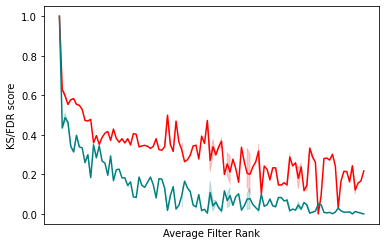

In [49]:
import seaborn as sns 
from matplotlib import pyplot as plt
sns.lineplot(data = KSFDR, x = 'avg_rank', y = 'KS', color = 'red')
sns.lineplot(data = KSFDR, x = 'avg_rank', y = 'FDR', color = 'teal')
plt.ylabel('KS/FDR score')
plt.xlabel('Average Filter Rank')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

In [50]:
filtered = KSFDR.iloc[1:81, :]

In [51]:
filtered.shape

(80, 6)

In [52]:
filtered.head()

,VarName,KS,FDR,rank_KS,rank_FDR,avg_rank
140,median_amount_by_cardnum_merchnum_in_last_14_days,0.630007,0.434447,317.5,299.5,308
171,total_amount_by_cardnum_merchnum_in_last_30_days,0.630007,0.434447,317.5,299.5,308
137,median_amount_by_cardnum_merchnum_in_last_1_days,0.630007,0.434447,317.5,299.5,308
138,median_amount_by_cardnum_merchnum_in_last_3_days,0.630007,0.434447,317.5,299.5,308
139,median_amount_by_cardnum_merchnum_in_last_7_days,0.630007,0.434447,317.5,299.5,308


In [53]:
topVarNames = list(filtered['VarName'])

In [54]:
topVars_df = fsdf[topVarNames]       
topVars_df['Fraud'] = fsdf['Fraud']

<ipython-input-54-2be79fcc5f89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topVars_df['Fraud'] = fsdf['Fraud']


In [55]:
#topVars_df = topVars_df.drop('dow', axis = 1)
topVars_df = topVars_df.reset_index().drop('index', axis = 1)
for col in topVars_df.columns:
    print(col, type(topVars_df[col][0]))

median_amount_by_cardnum_merchnum_in_last_14_days <class 'numpy.float64'>
total_amount_by_cardnum_merchnum_in_last_30_days <class 'numpy.float64'>
median_amount_by_cardnum_merchnum_in_last_1_days <class 'numpy.float64'>
median_amount_by_cardnum_merchnum_in_last_3_days <class 'numpy.float64'>
median_amount_by_cardnum_merchnum_in_last_7_days <class 'numpy.float64'>
median_amount_by_cardnum_merchnum_in_last_30_days <class 'numpy.float64'>
total_amount_by_cardnum_merchnum_in_last_0_days <class 'numpy.float64'>
total_amount_by_cardnum_merchnum_in_last_14_days <class 'numpy.float64'>
total_amount_by_cardnum_merchnum_in_last_7_days <class 'numpy.float64'>
total_amount_by_cardnum_merchnum_in_last_1_days <class 'numpy.float64'>
total_amount_by_cardnum_merchnum_in_last_3_days <class 'numpy.float64'>
median_amount_by_cardnum_merchnum_in_last_0_days <class 'numpy.float64'>
total_amount_by_cardnum_zip_in_last_14_days <class 'numpy.float64'>
max_amount_by_cardnum_merchnum_in_last_1_days <class 'nump

Now that we have a dataframe with our KSFDR average rank, we can take a certain number of variables off the top and run them through a logistic regression wrapper. 

## Wrapper

In [56]:
data = topVars_df.drop('Fraud', axis = 1).reset_index().drop('index', axis=1)
Y = topVars_df['Fraud']

In [57]:
#%pip install mlxtend

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
model = DecisionTreeClassifier(criterion = 'gini', max_depth = 10)

sfs = SFS(model, k_features = 79, forward = True, verbose = 2, scoring = 'accuracy', cv = 0)
sfs.fit(data,Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    7.8s finished

[2021-05-08 12:51:42] Features: 1/79 -- score: 0.996491413894001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    9.5s finished

[2021-05-08 12:51:51] Features: 2/79 -- score: 0.997312290643329[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   12.9s finished

[2021-05-08 12:52:04] Features: 3/79 -- score: 0.9979875279693893[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:  1.5min finished

[2021-05-08 13:16:50] Features: 28/79 -- score: 0.9990334838274041[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:  1.5min finished

[2021-05-08 13:18:20] Features: 29/79 -- score: 0.9990334838274041[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:  1.5min finished

[2021-05-08 13:19:51] Features: 30/79 -- score: 0.9990334838274041[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.5min finished

[2021-05-08 13:21:22] Features: 31/

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.3min finished

[2021-05-08 13:58:45] Features: 56/79 -- score: 0.9990334838274041[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.2min finished

[2021-05-08 13:59:58] Features: 57/79 -- score: 0.9990334838274041[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  1.2min finished

[2021-05-08 14:01:11] Features: 58/79 -- score: 0.9990334838274041[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done

SequentialFeatureSelector(cv=0, estimator=DecisionTreeClassifier(max_depth=10),
                          k_features=79, scoring='accuracy', verbose=2)

C:\Users\zapcu\anaconda3\new\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\zapcu\anaconda3\new\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


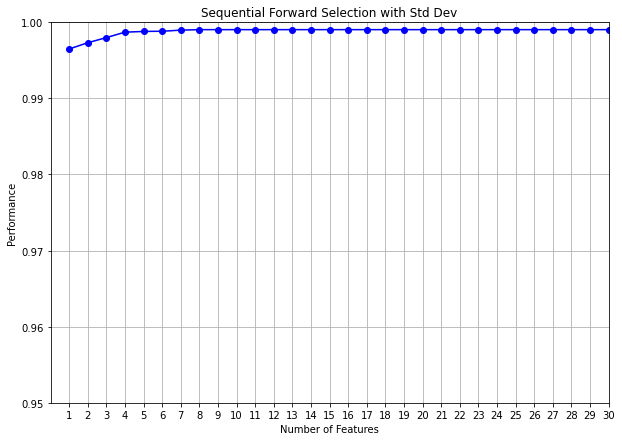

In [69]:
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(),
                kind = 'std_dev', 
                figsize = (10,7))

plt.ylim([.95,1])
plt.xlim(0,30)
plt.title('Sequential Forward Selection with Std Dev')
plt.grid()
plt.show()

In [60]:
vars_SBS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

### Obtain list of top variables that we want to keep for our model

In [61]:
Num_features_to_select = 15
top30final = list(vars_SBS.iloc[Num_features_to_select,:]['feature_names'])
top30final.append('Fraud')

In [62]:
top30final

['median_amount_by_cardnum_merchnum_in_last_14_days',
 'total_amount_by_cardnum_merchnum_in_last_30_days',
 'median_amount_by_cardnum_merchnum_in_last_1_days',
 'median_amount_by_cardnum_merchnum_in_last_3_days',
 'median_amount_by_cardnum_merchnum_in_last_7_days',
 'median_amount_by_cardnum_merchnum_in_last_30_days',
 'total_amount_by_cardnum_merchnum_in_last_0_days',
 'total_amount_by_cardnum_merchnum_in_last_14_days',
 'total_amount_by_cardnum_merchnum_in_last_7_days',
 'max_amount_by_cardnum_zip_in_last_30_days',
 'mean_amount_by_cardnum_state_in_last_14_days',
 'mean_amount_by_cardnum_zip_in_last_14_days',
 'max_amount_by_cardnum_state_in_last_0_days',
 'mean_amount_by_cardnum_merchnum_in_last_1_days',
 'Amount',
 'total_amount_by_Cardnum_in_last_0_days',
 'Fraud']

In [71]:
pd.Series(top30final).to_csv('topVars.csv')

# Modeling

## Prep data for modeling

In [63]:
full_df_filtered = final[top30final]
full_df_filtered.shape

(96397, 17)

In [64]:
full_df_filtered.to_csv('filtered_df_v2.csv', index = False)

In [65]:
train_test30 = final[final['Date'] < '2010-10-01']
oot30 = final[final['Date'] >= '2010-10-01']

train_test30 = train_test30[top30final]
oot30 = oot30[top30final]

In [66]:
oot30.shape[0] + train_test30.shape[0]

96397

In [67]:
oot30.head()

,median_amount_by_cardnum_merchnum_in_last_14_days,total_amount_by_cardnum_merchnum_in_last_30_days,median_amount_by_cardnum_merchnum_in_last_1_days,median_amount_by_cardnum_merchnum_in_last_3_days,median_amount_by_cardnum_merchnum_in_last_7_days,median_amount_by_cardnum_merchnum_in_last_30_days,total_amount_by_cardnum_merchnum_in_last_0_days,total_amount_by_cardnum_merchnum_in_last_14_days,total_amount_by_cardnum_merchnum_in_last_7_days,max_amount_by_cardnum_zip_in_last_30_days,mean_amount_by_cardnum_state_in_last_14_days,mean_amount_by_cardnum_zip_in_last_14_days,max_amount_by_cardnum_state_in_last_0_days,mean_amount_by_cardnum_merchnum_in_last_1_days,Amount,total_amount_by_Cardnum_in_last_0_days,Fraud
78867,65547.52,65547.52,65547.52,65547.52,65547.52,65547.52,65547.52,65547.52,65547.52,2499.05,1255.448491,1285.245490,2499.05,1285.245490,889.99,261241.77,0
78868,6057.00,6057.00,6057.00,6057.00,6057.00,6057.00,6057.00,6057.00,6057.00,572.25,476.610435,432.642857,1031.00,432.642857,525.00,51607.09,0
78869,619.68,619.68,619.68,619.68,619.68,619.68,619.68,619.68,619.68,6893.59,1873.841786,1379.926531,8422.69,309.840000,309.84,5864185.44,0
78870,98.92,98.92,98.92,98.92,98.92,98.92,98.92,98.92,98.92,59.64,187.520833,52.853333,775.00,49.460000,49.46,18856.98,0
78871,145.52,145.52,145.52,145.52,145.52,145.52,145.52,145.52,145.52,145.52,117.377442,145.520000,398.00,145.520000,145.52,243121.48,0


In [68]:
train_test30.to_csv('train_test_filtered_v2.csv', index = False)
oot30.to_csv('oot_filtered_v2.csv', index = False)

In [ ]:
#now we have our train/test set (which we'll now split into training and testing for modeling) 
#and we have our oot dataset for the 30 top fields that we've selected. 

from sklearn.model_selection import train_test_split as tts
X = train_test30.drop('Fraud', axis = 1)
y = train_test30['Fraud']

X_train, X_test, y_train, y_test = tts(X, y, test_size = .3, stratify = y, random_state = 11)

Let's build some models!

In [ ]:
X_train

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [ ]:
#lr1

In [ ]:
lr1_X_train = X_train.copy()
lr1_X_test = X_test.copy()
lr1_oot = oot30.copy().drop('Fraud', axis=1)
lr1 = LogisticRegression(penalty = 'none', max_iter = 2000).fit(lr1_X_train, y_train)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF

In [ ]:
rf1_X_train = X_train.copy()
rf1_X_test = X_test.copy()
rf1_oot = oot30.copy().drop('Fraud', axis=1)
rf1 = RF(n_estimators = 50, max_depth = 100).fit(rf1_X_train, y_train)

In [ ]:
rf2_X_train = X_train.copy()
rf2_X_test = X_test.copy()
rf2_oot = oot30.copy().drop('Fraud', axis=1)
rf2 = RF(n_estimators = 100, max_depth = 100).fit(rf2_X_train, y_train)

In [ ]:
rf3_X_train = X_train.copy()
rf3_X_test = X_test.copy()
rf3_oot = oot30.copy().drop('Fraud', axis=1)
rf3 = RF(n_estimators = 150, max_depth = 100).fit(rf3_X_train, y_train)

In [ ]:
rf4_X_train = X_train.copy()
rf4_X_test = X_test.copy()
rf4_oot = oot30.copy().drop('Fraud', axis=1)
rf4 = RF(n_estimators = 100, max_depth = 200).fit(rf4_X_train, y_train)

In [ ]:
rf5_X_train = X_train.copy()
rf5_X_test = X_test.copy()
rf5_oot = oot30.copy().drop('Fraud', axis=1)
rf5 = RF(n_estimators = 50, max_depth = 500).fit(rf1_X_train, y_train)

In [ ]:
rf6_X_train = X_train.copy()
rf6_X_test = X_test.copy()
rf6_oot = oot30.copy().drop('Fraud', axis=1)
rf6 = RF(n_estimators = 100, min_samples_split = 100).fit(rf6_X_train, y_train)

In [ ]:
rf7_X_train = X_train.copy()
rf7_X_test = X_test.copy()
rf7_oot = oot30.copy().drop('Fraud', axis=1)
rf7 = RF(n_estimators = 100, max_depth = 200, criterion = 'entropy').fit(rf7_X_train, y_train)

### Neural Net

In [ ]:
from sklearn.neural_network import MLPClassifier as NN

In [ ]:
nn1_X_train = X_train.copy()
nn1_X_test = X_test.copy()
nn1_oot = oot30.copy().drop('Fraud', axis=1)
nn1 = NN(hidden_layer_sizes = (10,), max_iter = 20).fit(nn1_X_train, y_train)

In [ ]:
nn2_X_train = X_train.copy()
nn2_X_test = X_test.copy()
nn2_oot = oot30.copy().drop('Fraud', axis=1)
nn2 = NN(hidden_layer_sizes = (5,), max_iter = 30).fit(nn2_X_train, y_train)

In [ ]:
nn3_X_train = X_train.copy()
nn3_X_test = X_test.copy()
nn3_oot = oot30.copy().drop('Fraud', axis=1)
nn3 = NN(hidden_layer_sizes = (15,), max_iter = 40).fit(nn3_X_train, y_train)

In [ ]:
nn4_X_train = X_train.copy()
nn4_X_test = X_test.copy()
nn4_oot = oot30.copy().drop('Fraud', axis=1)
nn4 = NN(hidden_layer_sizes = (5,), max_iter = 40, learning_rate = 'adaptive').fit(nn4_X_train, y_train)

In [ ]:
nn5_X_train = X_train.copy()
nn5_X_test = X_test.copy()
nn5_oot = oot30.copy().drop('Fraud', axis=1)
nn5 = NN(hidden_layer_sizes = (5,), max_iter = 40, activation = 'tanh').fit(nn5_X_train, y_train)

### Boosted Tree

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [ ]:
bt1_X_train = X_train.copy()
bt1_X_test = X_test.copy()
bt1_oot = oot30.copy().drop('Fraud', axis=1)
bt1 = GBC(n_estimators = 500, max_depth = 3).fit(bt1_X_train, y_train)

In [ ]:
bt2_X_train = X_train.copy()
bt2_X_test = X_test.copy()
bt2_oot = oot30.copy().drop('Fraud', axis=1)
bt2 = GBC(n_estimators = 750, max_depth = 4).fit(bt2_X_train, y_train)

In [ ]:
bt3_X_train = X_train.copy()
bt3_X_test = X_test.copy()
bt3_oot = oot30.copy().drop('Fraud', axis=1)
bt3 = GBC(n_estimators = 500, max_depth = 3, loss = 'exponential').fit(bt1_X_train, y_train)

In [ ]:
bt4_X_train = X_train.copy()
bt4_X_test = X_test.copy()
bt4_oot = oot30.copy().drop('Fraud', axis=1)
bt4 = GBC(n_estimators = 500, max_depth = 3, learning_rate = 0.01).fit(bt4_X_train, y_train)

In [ ]:
bt5_X_train = X_train.copy()
bt5_X_test = X_test.copy()
bt5_oot = oot30.copy().drop('Fraud', axis=1)
bt5 = GBC(n_estimators = 1000, max_depth = 3, learning_rate = 0.001).fit(bt5_X_train, y_train)

## Get FDR for all models 

In [ ]:
modList = [lr1, rf1, rf2, rf3, rf4, rf5, rf6, rf7, nn1, nn2, nn3, nn4, nn5, bt1, bt2, bt3, bt4, bt5]
train_list = [lr1_X_train, rf1_X_train, \
             rf2_X_train, rf3_X_train, rf4_X_train, rf5_X_train, rf6_X_train, rf7_X_train, nn1_X_train,\
             nn2_X_train, nn3_X_train, nn4_X_train, nn5_X_train, bt1_X_train, bt2_X_train, bt3_X_train, bt4_X_train, bt5_X_train]
test_list = [lr1_X_test, rf1_X_test,\
            rf2_X_test, rf3_X_test, rf4_X_test, rf5_X_test, rf6_X_test, rf7_X_test, nn1_X_test, nn2_X_test, \
            nn3_X_test, nn4_X_test, nn5_X_test, bt1_X_test, bt2_X_test, bt3_X_test, bt4_X_train, bt5_X_train]
oot_list = [lr1_oot, rf1_oot, rf2_oot, rf3_oot, rf4_oot, rf5_oot, rf6_oot,\
           rf7_oot, nn1_oot, nn2_oot, nn3_oot, nn4_oot, nn5_oot, bt1_oot, bt2_oot, bt3_oot, bt4_oot, bt5_oot]

### On the training data...

In [ ]:
training_FDRs = []
i = 0
for model in modList:
    train_set = train_list[i]
    i+=1
    temp = train_set.copy()
    temp['scores'] = 0
    temp['scores'] = model.predict_proba(train_set)
    cutpoint = int(len(temp)*(.03))
    top3percent = temp.sort_values(by = 'scores', ascending = True).iloc[:cutpoint,:]
    FDR = train_test30.loc[top3percent.index, 'Fraud'].sum()/train_test30.loc[train_set.index, 'Fraud'].sum()
    training_FDRs.append(FDR)

### On the testing data...

In [ ]:
testing_FDRs = []
i = 0
for model in modList:
    test_set = test_list[i]
    i+=1
    temp = test_set.copy()
    temp['scores'] = 0
    temp['scores'] = model.predict_proba(test_set)
    cutpoint = int(len(temp)*(.03))
    top3percent = temp.sort_values(by = 'scores', ascending = True).iloc[:cutpoint,:]
    FDR = train_test30.loc[top3percent.index, 'Fraud'].sum()/train_test30.loc[test_set.index, 'Fraud'].sum()
    testing_FDRs.append(FDR)

### And on the OOT data...

In [ ]:
oot_FDRs = []
i = 0
for model in modList:
    oot_set = oot_list[i]
    i+=1
    temp = oot_set.copy()
    temp['scores'] = 0
    temp['scores'] = model.predict_proba(oot_set)
    cutpoint = int(len(temp)*(.03))
    top3percent = temp.sort_values(by = 'scores', ascending = True).iloc[:cutpoint,:]
    FDR = oot30.loc[top3percent.index, 'Fraud'].sum()/oot30['Fraud'].sum()
    oot_FDRs.append(FDR)

In [ ]:
FDRdict = {'Model': modList, 'trainingFDR':training_FDRs, 'testingFDR':testing_FDRs, 'ootFDR':oot_FDRs}
modelFDRs = pd.DataFrame(FDRdict)

In [ ]:
modelFDRs

In [ ]:
## plot the top 10 features in terms of Gini index
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600)
sorted_idx = rf1.feature_importances_.argsort() ## remove [-10:] to get a plot for all features
plt.barh(X_train.columns[sorted_idx], rf1.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")